In [1]:
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import verdict

In [2]:
import matplotlib.pyplot as plt

# Parameters

In [3]:
sample_number = 0

# Load Mock Data

In [4]:
# Load using my preferred wrapper for hdf5 files.
data = verdict.Dict.from_hdf5( './data/observers_file.h5' )

# Assign Errors

Our goal is to create semi-realistic errors.
We won't put too much effort into this, so we'll roughly fit a gamma function to the distribution of errors from COS-Halos data, and sample from the distribution.
We do provide a bound on 1.5 the maximum observed error, however, to prevent getting anything too crazy.

## Derive Errors from Data

In [5]:
df = pd.read_fwf(
    './data/cos_halos_data.txt',
    skiprows = 31,
    names = [ 'ID', 'z', 'Ion', 'Vel', 'e_Vel', 'b', 'e_b', 'logN', 'elogN', 'l_logNA', ',logNA', 'e_logNA' ],
)

In [6]:
# Find ions used
ions = list( set( df['Ion'] ) )
ions.remove( np.nan )
ions.append( 'H I' )

In [7]:
# Get out errors from data, mildly processed
elogNs = {}
for ion in ions:
        
    if ion != 'H I':
        # Locate
        ion_df = df[df['Ion'] == ion]
        elogN = []
        for e in ion_df['elogN'].values:
            try:
                elogN.append( float( e ) )
            except ValueError:
                continue
    else:
        # Manual H I input from COS-Halos hydrogen paper
        elogN = [ 0.03, 0.05, 0.05, 0.03, 0.09, 0.03, 0.15, 0.15, 0.08, 0.06, 0.03, 0.06, 0.03, 0.04, 0.03, 0.13, 0.06, 0.04, 0.05, 0.06, 0.02, 0.04, 0.06, 0.04, 0.04, 0.03, 0.07, 0.06, 0.10, 0.12, 0.06, 0.02, 0.03, 0.09, 0.04, 0.03, 0.04, ]

    elogNs[ion] = np.array( elogN )

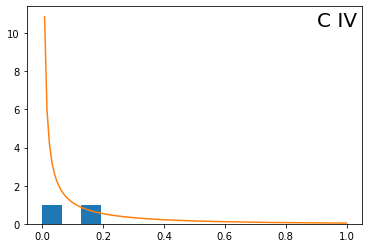

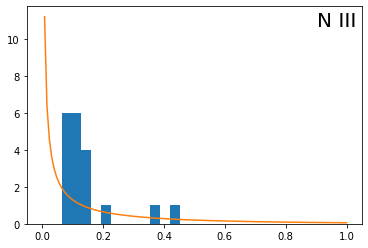

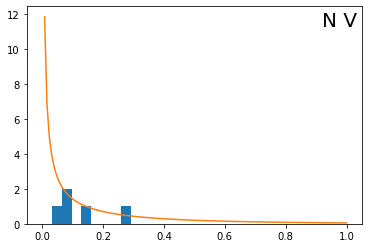

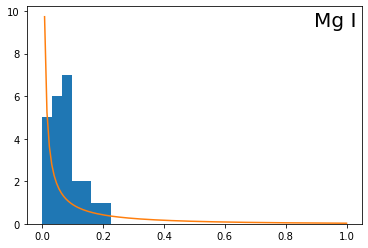

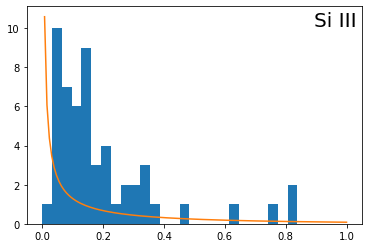

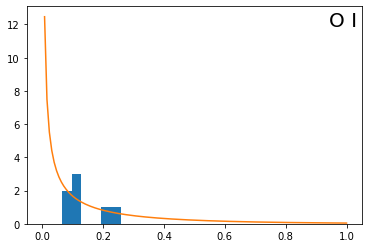

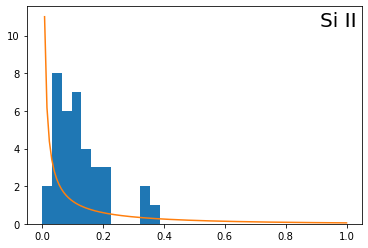

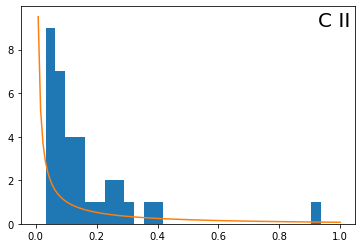

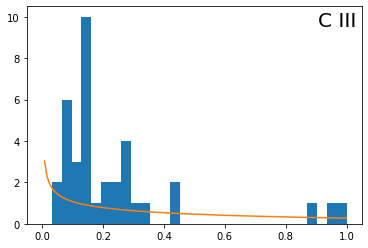

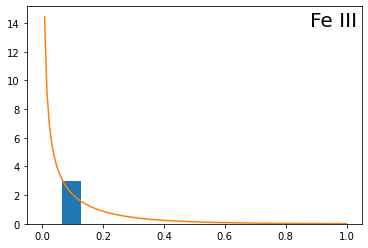

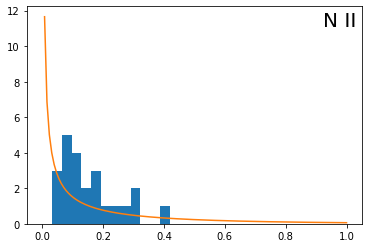

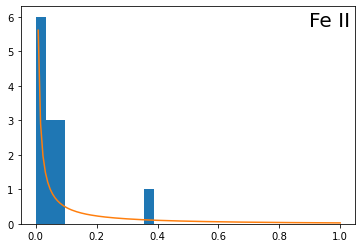

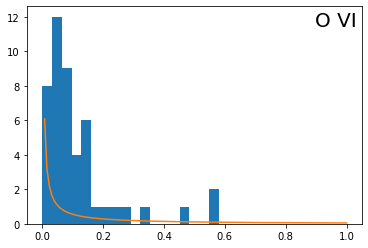

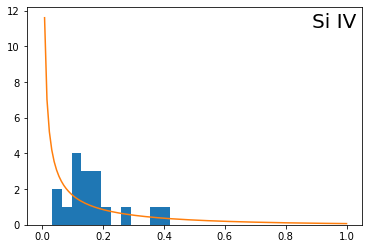

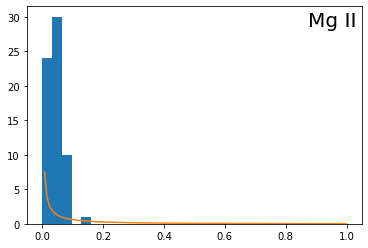

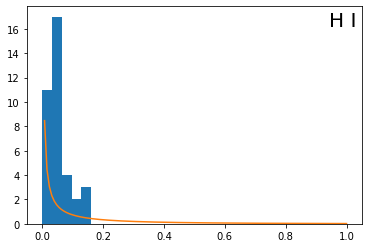

In [8]:
# Stats of the errors

errs = {}
for ion in ions:
    
    elogN = elogNs[ion]

    # Extract
    errs[ion] = {
        'mean': np.mean( elogN ),
        'std': np.std( elogN ),
    }
    
    
    # Create a gamma fn, *very* roughly fitted
    beta = errs[ion]['mean'] / errs[ion]['std']
    alpha = errs[ion]['mean'] * beta
    dist = scipy.stats.gamma( a=alpha, scale=1/beta  )
    
    # Plot and store
    fig = plt.figure()
    ax = plt.gca()
    ax.hist(
        elogN,
        bins = np.linspace( 0, 1, 32 )
    )
    ax.plot(
        np.linspace( 0, 1., 128 ),
        dist.pdf( np.linspace( 0, 1., 128 ) ),
    )
    ax.annotate(
        s = ion,
        xy = ( 1, 1 ),
        xytext = ( -5, -5 ),
        va = 'top',
        ha = 'right',
        xycoords = 'axes fraction',
        textcoords = 'offset points',
        fontsize = 20,
    )
    errs[ion]['dist'] = dist

## Apply to Data

In [9]:
data_out = {}
for ion in data.keys():
    
    dist = errs[ion]['dist']
    
    ion_errs = []
    modified_columns = []
    for i, column in enumerate( data[ion] ):
        
        ion_err = np.inf
        while ( ion_err > elogNs[ion].max()*1.5 ) or ( ion_err < elogNs[ion].min() / 1.5 ):
            ion_err = dist.rvs()
            
        # Assume error is conservative, apply
        modified_column = column * 10.**np.random.uniform( -ion_err, ion_err )
        
        # Round and store
        ion_errs.append( np.round( ion_err, decimals=3 ) )
        modified_columns.append( np.round( np.log10( modified_column ), decimals=3 ) )
        
    data_out[ion] = {
        'logN': np.array( modified_columns ),
        'elogN': np.array( ion_errs ),
    }
data_out = verdict.Dict( data_out )

<ipython-input-9-1a3bbd98ad63>:19: RuntimeWarning: divide by zero encountered in log10
  modified_columns.append( np.round( np.log10( modified_column ), decimals=3 ) )


# Save Output

In [10]:
data_out.to_hdf5( './data/sample{}.h5'.format( sample_number ) )